In [53]:
import psycopg2
#import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline


def run_query(q):
    with psycopg2.connect("dbname=chinook user=postgres password=tsbsbsms") as conn:
        return pd.read_sql(q, conn)

def run_command(c):
    with psycopg2.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(c)

def show_tables():
    q = '''
   SELECT table_name
   FROM 
   information_schema.tables 
   WHERE 
   table_schema='public';
    '''
    return run_query(q)

show_tables()

,table_name
0,artist
1,employee
2,customer
3,invoice
4,invoice_line
5,playlist
6,playlist_track
7,album
8,genre
9,media_type


In [32]:
albums_to_purchase = '''
WITH usa_tracks_sold AS
   (
    SELECT il.* FROM invoice_line il
    INNER JOIN invoice i on il.invoice_id = i.invoice_id
    INNER JOIN customer c on i.customer_id = c.customer_id
    WHERE c.country = 'USA'
   )

SELECT
    g.name genre,
    count(uts.invoice_line_id) tracks_sold,
    cast(count(uts.invoice_line_id) AS FLOAT) / (
        SELECT COUNT(*) from usa_tracks_sold
    ) percentage_sold
FROM usa_tracks_sold uts
INNER JOIN track t on t.track_id = uts.track_id
INNER JOIN genre g on g.genre_id = t.genre_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10;
'''

run_query(albums_to_purchase)

,genre,tracks_sold,percentage_sold
0,Rock,157,0.317814
1,Latin,91,0.184211
2,Metal,64,0.129555
3,Alternative & Punk,50,0.101215
4,Jazz,22,0.044534
5,Blues,15,0.030364
6,TV Shows,14,0.028340
7,R&B/Soul,12,0.024291
8,Classical,8,0.016194
9,Comedy,8,0.016194


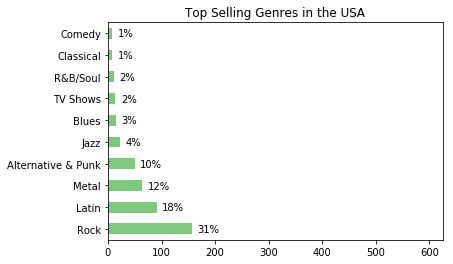

In [33]:
genre_sales_usa = run_query(albums_to_purchase)
genre_sales_usa.set_index("genre", inplace=True, drop=True)

genre_sales_usa["tracks_sold"].plot.barh(
    title="Top Selling Genres in the USA",
    xlim=(0, 625),
    colormap=plt.cm.Accent
)

plt.ylabel('')

for i, label in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[label, "tracks_sold"]
    label = (genre_sales_usa.loc[label, "percentage_sold"] * 100
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15))

plt.show()


In [45]:
employee_sales_performance = '''
WITH customer_support_rep_sales AS
    (
     SELECT
         i.customer_id,
         c.support_rep_id,
         SUM(i.total) total
     FROM invoice i
     INNER JOIN customer c ON i.customer_id = c.customer_id
     GROUP BY 1,2
    )

SELECT
    e.first_name || '' || e.last_name employee,
    e.hire_date,
    SUM(csrs.total) total_sales
FROM customer_support_rep_sales csrs
INNER JOIN employee e ON e.employee_id = csrs.support_rep_id
GROUP BY 1,2;
'''

run_query(employee_sales_performance)

,employee,hire_date,total_sales
0,SteveJohnson,2003-10-17,720.16
1,MargaretPark,2003-05-03,775.40
2,JanePeacock,2002-04-01,833.04


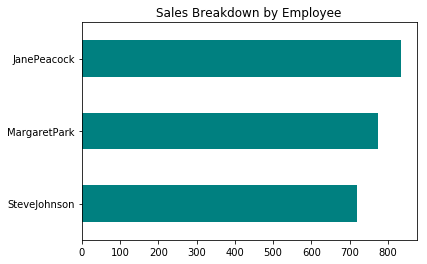

In [83]:
employee_sales = run_query(employee_sales_performance)
employee_sales.set_index("employee", drop=True, inplace=True)
employee_sales.sort_values("total_sales", inplace=True)
#employee_sales['total_sales'].astype(float)
employee_sales['total_sales'].plot.barh(
legend=False,
    title='Sales Breakdown by Employee',color='teal'
    )
plt.ylabel('')
plt.show()

In [119]:
sales_by_country = '''
WITH country_or_other AS
   ( SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN 'other'
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
	 )
	 SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
	 (
	 SELECT
        country,
        count(distinct customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / count(distinct customer_id) customer_lifetime_value,
        SUM(unit_price) / count(distinct invoice_id) average_order,
        CASE
            WHEN country = 'other' THEN 1
            ELSE 0
         END as sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort asc,total_sales desc
) AS foo
'''
    

run_query(sales_by_country)

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,523.06,5.747912,40.235385
1,Canada,8,303.96,5.427857,37.995000
2,France,5,195.10,5.574286,39.020000
3,Brazil,5,190.10,5.431429,38.020000
4,Germany,4,156.48,5.588571,39.120000
5,United Kingdom,3,112.86,5.374286,37.620000
6,Czech Republic,2,90.24,6.445714,45.120000
7,Portugal,2,77.24,5.517143,38.620000
8,India,2,75.26,5.789231,37.630000
9,other,15,604.30,5.755238,40.286667


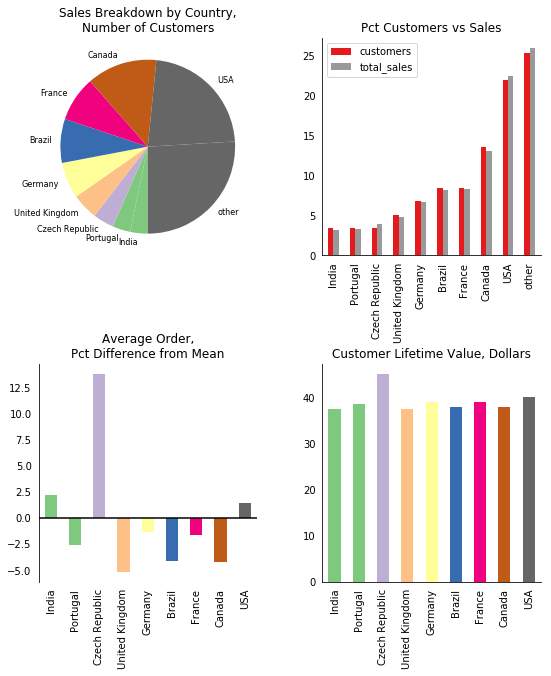

In [109]:
country_metrics = run_query(sales_by_country)
country_metrics.set_index("country", drop=True, inplace=True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_metrics.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)


# top left
sales_breakdown = country_metrics["total_sales"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0}
    
)

# top right
cvd_cols = ["customers","total_sales"]
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
     custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct Customers vs Sales"
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)


# bottom left
avg_order = country_metrics["average_order"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)
# bottom right
ltv = country_metrics["customer_lifetime_value"].copy()
ltv.index.name = ''
ltv.drop("other",inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Lifetime Value, Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()

In [42]:
cur=conn.cursor()
cur.execute("select * from employee limit 1")
all=cur.fetchall()
all


[(1,
  'Adams',
  'Andrew',
  'General Manager',
  None,
  datetime.datetime(1962, 2, 18, 0, 0),
  datetime.datetime(2002, 8, 14, 0, 0),
  '11120 Jasper Ave NW',
  'Edmonton',
  'AB',
  'Canada',
  'T5K 2N1',
  '+1 (780) 428-9482',
  '+1 (780) 428-3457',
  'andrew@chinookcorp.com')]

In [67]:
speed = [0.1, 17.5, 40, 48, 52, 69, 88]
lifespan = [2, 8, 70, 1.5, 25, 12, 28]
index = ['snail', 'pig', 'elephant',
          'rabbit', 'giraffe', 'coyote', 'horse']
df = pd.DataFrame({'speed': speed,
                    'lifespan': lifespan}, index=index)
df

,lifespan,speed
snail,2.0,0.1
pig,8.0,17.5
elephant,70.0,40.0
rabbit,1.5,48.0
giraffe,25.0,52.0
coyote,12.0,69.0
horse,28.0,88.0


In [163]:
albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      )  percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                  EXCEPT 
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
                 AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                  EXCEPT 
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN 'yes'
             ELSE 'no'
         END AS album_purchase 
     FROM invoice_first_track select ifs 
    
    ) GROUP BY album_purchase AS wtf;  
''' 

run_query(albums_vs_tracks)

DatabaseError: Execution failed on sql '
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      )  percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                  EXCEPT 
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
                 AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                  EXCEPT 
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN 'yes'
             ELSE 'no'
         END AS album_purchase 
     FROM invoice_first_track select ifs 
    
    ) GROUP BY album_purchase AS wtf;  
': syntax error at or near "select"
LINE 47:      FROM invoice_first_track select ifs 
                                       ^
